In [1]:
import random
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import pandas as pd
#import imageio
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

import matplotlib.pyplot as plt
%matplotlib inline
import math

import optuna#载入optuna优化包

device = torch.device("cpu")

SEED = 1234#固定种子，大家都可以重复结果
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED) 
torch.backends.cudnn.deterministic = True
###########训练数据
xtrain = torch.unsqueeze(torch.linspace(-1, 1, 21), dim=1).to(device)
ytrain = (torch.sin(math.pi*xtrain) + 0.2*torch.randn(xtrain.size())).to(device)  # 这里是污染数据固定不变当成训练数据
#噪声注入输入数据方法

#测试数据
SEED = 666
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED) 
torch.backends.cudnn.deterministic = True

ytest = (torch.sin(math.pi*xtrain) + 0.2*torch.randn(xtrain.size())).to(device)

In [2]:
class Net(torch.nn.Module):  # 定义网络
    def __init__(self, n_feature, n_hidden1, n_output):
        super(Net, self).__init__()
        self.hidden1 = torch.nn.Linear(n_feature, n_hidden1)  # 全连接层
        self.predict = torch.nn.Linear(n_hidden1, n_output)   # 输出层

    def forward(self, x):
        x = self.hidden1(x)
        x = torch.sigmoid(x)
        x = self.predict(x)  # 前向传播过程
        return x  

    def reset_parameters(self):
        # 重新初始化网络参数
        self.hidden1.reset_parameters()
        self.predict.reset_parameters()
#经典的sigmoid神经网络1*n_hidden1*1，中间隐层为sigmoid函数
#这里把Net Class放在循环外面，对于不同的噪声注入数据，采用net.reset_parameters()对于网络进行重置

net = Net(n_feature=1, n_hidden1=10, n_output=1)#定义1*10*1的网络
optimizer = torch.optim.Adam(net.parameters(), lr=0.01,betas=(0.96,0.96))
#Adam算法，学习率是固定的0.01，矩参数是0.96
loss_func = torch.nn.MSELoss().to(device)  # loss函数是均方误差mse

In [3]:
# 定义神经网络训练代码
from tqdm import tqdm

epoch = 20000

inputx = torch.unsqueeze(torch.linspace(-1, 1, 401), dim=1).to(device)


def train_net(std_dev):
    output = torch.zeros(inputx.shape).to(device)  # 在函数内部初始化 output
    
    output.zero_()  # 清零张量

    SEED = 1234  # 固定种子
    np.random.seed(SEED)
    random.seed(SEED) 

    net.reset_parameters()
    
    for t in range(epoch):
        prediction = net(xtrain)
        loss = loss_func(prediction, ytrain)
        
        optimizer.zero_grad()
        loss.backward()
        
        # 在更新参数之前，为每个参数添加高斯噪声
        for param in net.parameters():
            noise = torch.randn_like(param) * std_dev  # 标准高斯噪声乘以标准差
            param.data.add_(noise)
            
        optimizer.step()

    output = net(inputx)  
    
    # 泛化误差
    losstest = loss_func(ytest, output[::20])
    return losstest

def objective(trial):
    std_dev = trial.suggest_float("std_dev", 0.0, 1)  # 优化参数 std_dev 的取值范围
    losstest = train_net(std_dev)
    return losstest

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

for trial in study.trials:
    print(f"Trial {trial.number}: Value = {trial.value}")

# 输出结果
print("Best trial:")
print("  Value: ", study.best_trial.value)
print("  Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

[I 2024-03-16 12:12:32,527] A new study created in memory with name: no-name-392dc391-6ee6-46ff-8da4-5c9ee4e10151
[I 2024-03-16 12:12:44,498] Trial 0 finished with value: 60.507347106933594 and parameters: {'std_dev': 0.2942695900925083}. Best is trial 0 with value: 60.507347106933594.
[I 2024-03-16 12:12:55,446] Trial 1 finished with value: 19.714122772216797 and parameters: {'std_dev': 0.24170843800042496}. Best is trial 1 with value: 19.714122772216797.
[I 2024-03-16 12:13:07,325] Trial 2 finished with value: 2344.60986328125 and parameters: {'std_dev': 0.5550597208323793}. Best is trial 1 with value: 19.714122772216797.
[I 2024-03-16 12:13:19,121] Trial 3 finished with value: 398.9256896972656 and parameters: {'std_dev': 0.6563401126984735}. Best is trial 1 with value: 19.714122772216797.
[I 2024-03-16 12:13:30,231] Trial 4 finished with value: 16.452205657958984 and parameters: {'std_dev': 0.1374407943253948}. Best is trial 4 with value: 16.452205657958984.
[I 2024-03-16 12:13:41,

Trial 0: Value = 60.507347106933594
Trial 1: Value = 19.714122772216797
Trial 2: Value = 2344.60986328125
Trial 3: Value = 398.9256896972656
Trial 4: Value = 16.452205657958984
Trial 5: Value = 620.2474975585938
Trial 6: Value = 341.5477600097656
Trial 7: Value = 561.647216796875
Trial 8: Value = 261.6100158691406
Trial 9: Value = 1745.93505859375
Trial 10: Value = 0.03589364513754845
Trial 11: Value = 0.046307273209095
Trial 12: Value = 0.04166620597243309
Trial 13: Value = 0.07645999640226364
Trial 14: Value = 8.185310363769531
Trial 15: Value = 3.798579692840576
Trial 16: Value = 0.06136577948927879
Trial 17: Value = 5.757040977478027
Trial 18: Value = 0.477820485830307
Trial 19: Value = 189.57611083984375
Trial 20: Value = 0.6301355361938477
Trial 21: Value = 0.06102915108203888
Trial 22: Value = 44.67397689819336
Trial 23: Value = 2.0863192081451416
Trial 24: Value = 0.22736600041389465
Trial 25: Value = 64.58981323242188
Trial 26: Value = 1.991395115852356
Trial 27: Value = 0.187

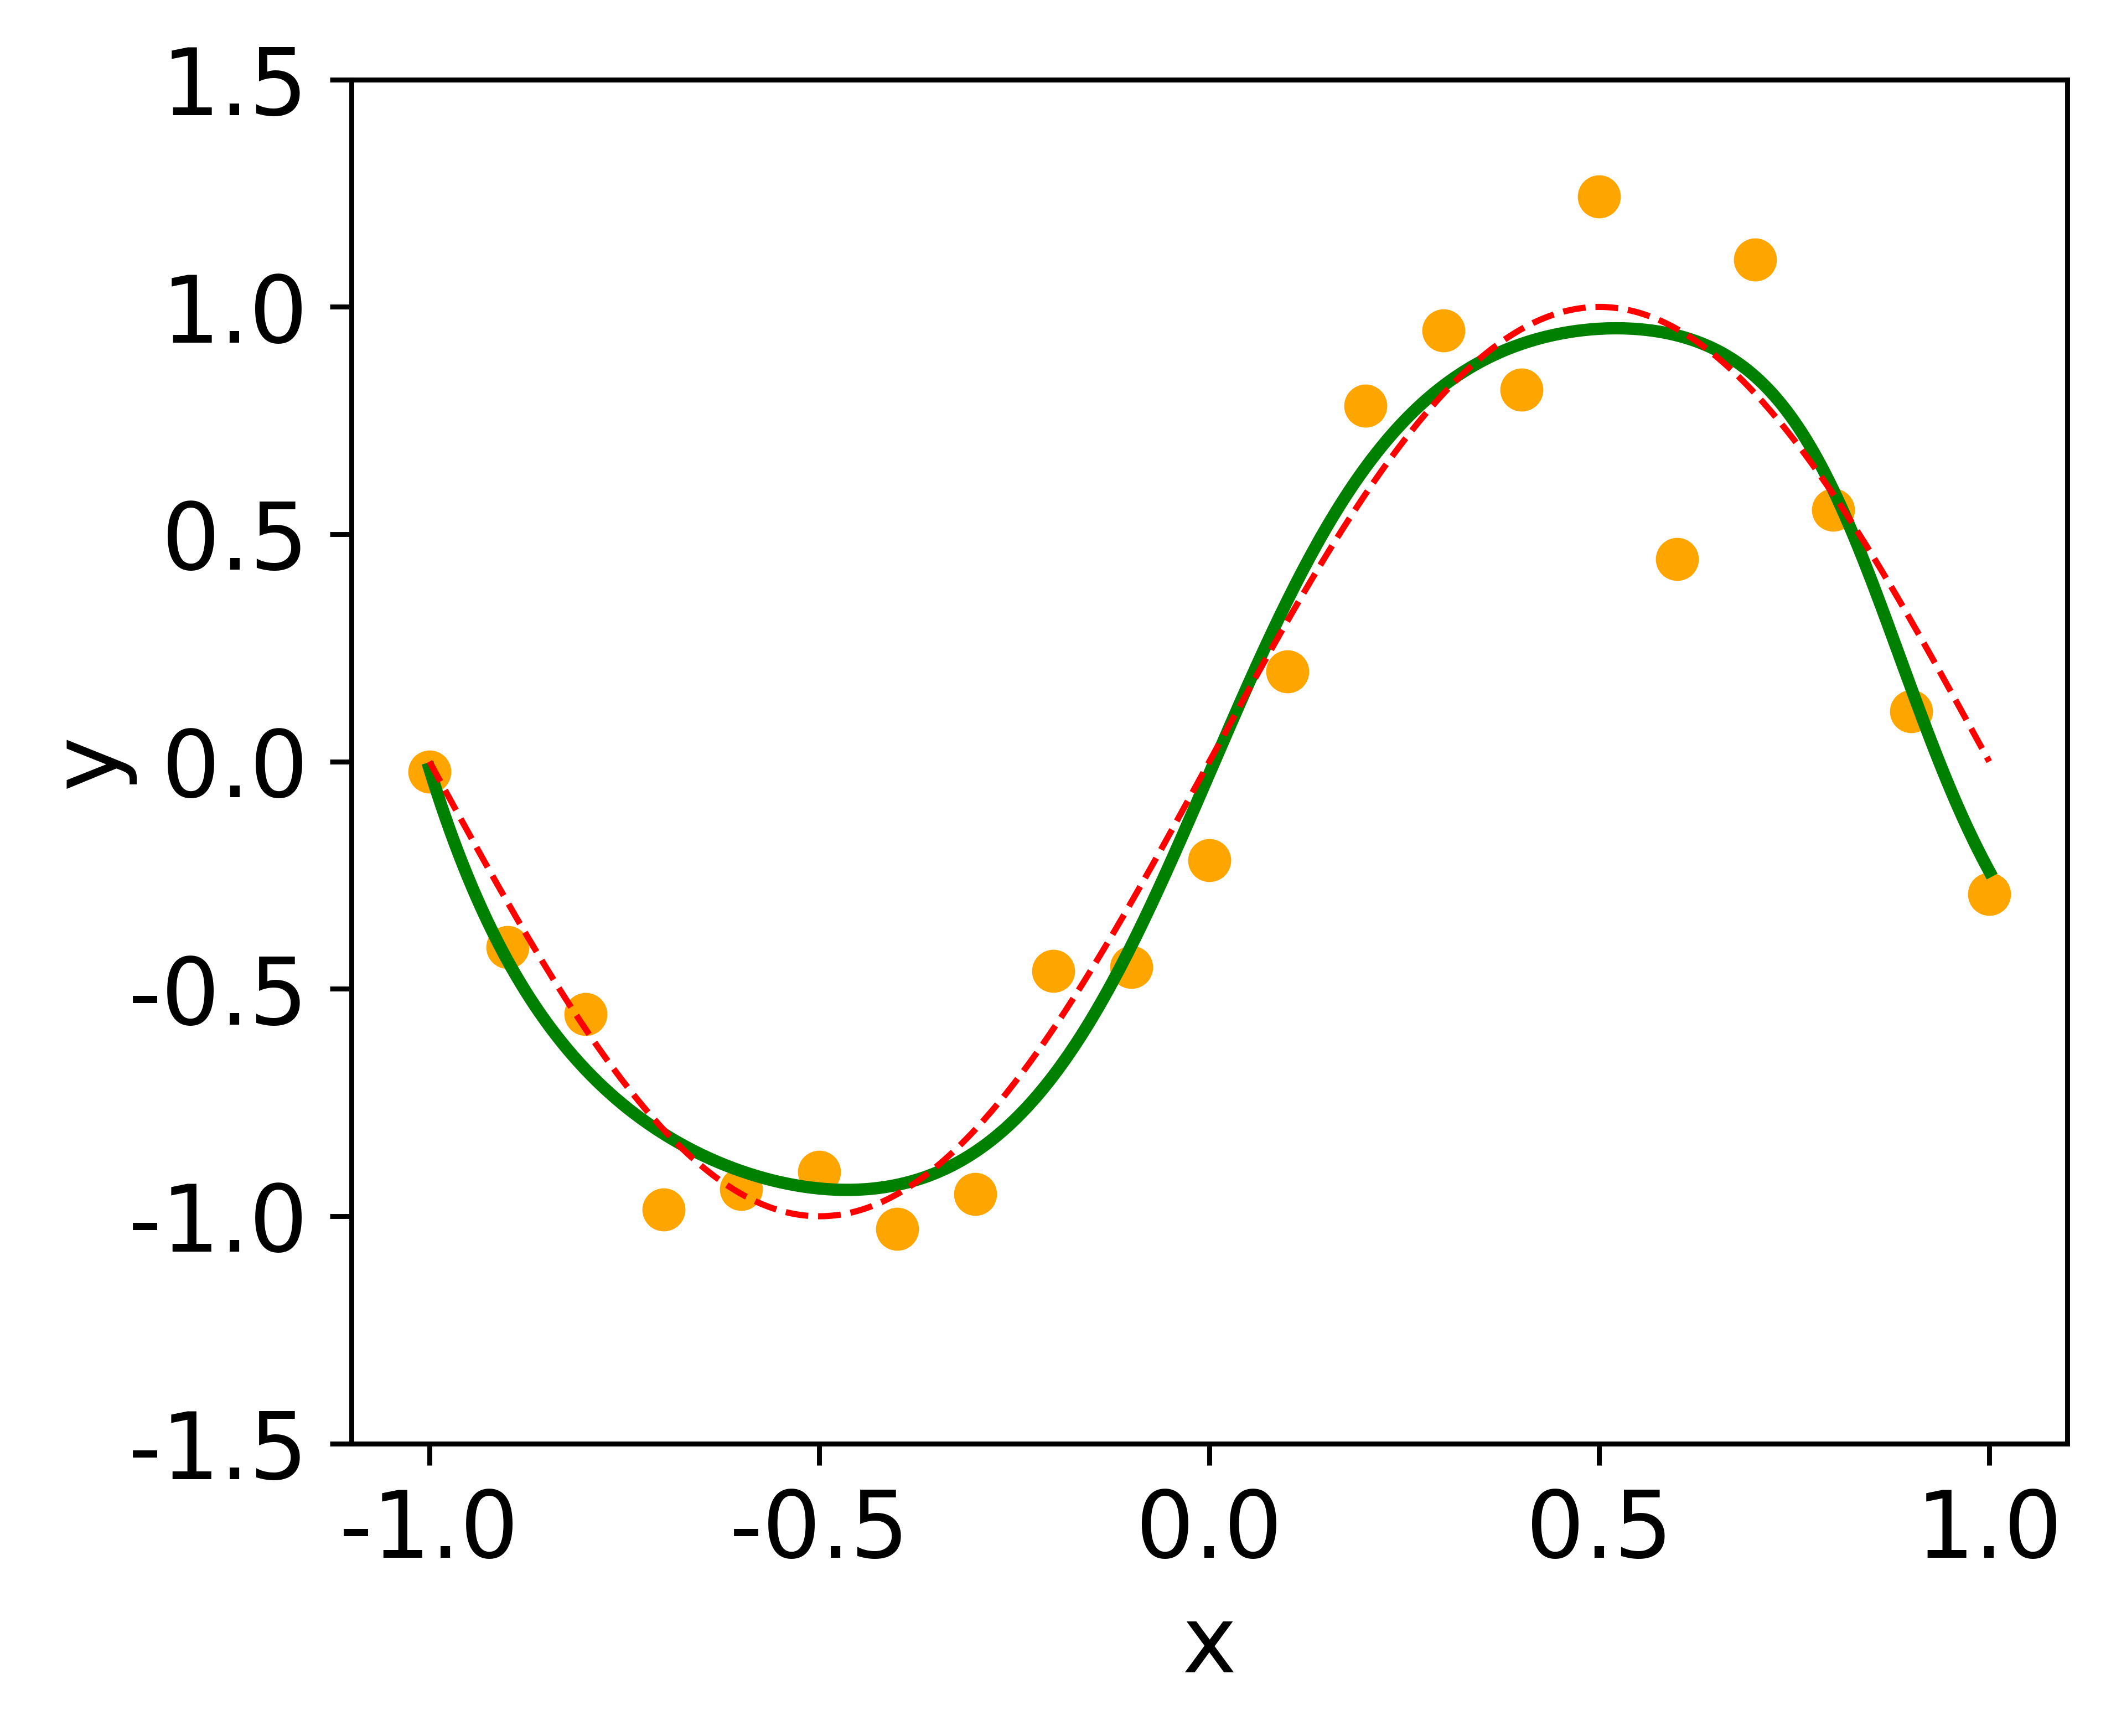

In [4]:
epoch = 20000#训练次数2万次

std_dev=0.009264843479406128#权系数上加噪声均方根大小
for t in range(epoch):
   
    prediction = net(xtrain)  # 网络前向过程
    loss = loss_func(prediction, ytrain) # 计算loss，通过prediction和y的差来计算mse
    
    optimizer.zero_grad()   # clear gradients for next train
    loss.backward(retain_graph=True)         # 反向传播！
    # 在更新参数之前，为每个参数添加高斯噪声
    for param in net.parameters():
        noise = torch.randn_like(param) * std_dev  # 标准高斯噪声乘以标准差
        param.data.add_(noise)
        
    optimizer.step() 
# 更新参数！
output = net(inputx)
##########################
#画出结果
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams ['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus']=False  # #用来正常显示负号
#plt.style.use(['science','ieee'])#如果找不到science plot包则载入这句话
fig, ax = plt.subplots(figsize=(5,4)) 
plt.cla()
plt.tick_params(labelsize=15)
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('y', fontsize=15, labelpad = -1)
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.5, 1.5)

# 训练集橘色的散点
ax.scatter(xtrain.data.numpy(), ytrain.data.numpy(), color="orange")
 # 非常密的输入和网络输出
ax.plot(inputx.data.numpy(), output.data.numpy(), 'g-', lw=2)
#真实信号
signal = torch.sin(math.pi*inputx)
ax.plot(inputx.data.numpy(), signal.data.numpy(), 'r--', lw=1,label='signal')